In [369]:
import matplotlib.pyplot as plt
class PlotError(Exception):
    pass
class CanvasSummaryVisualizer:
    def __init__(self, data):
        self.data = data

    def plot_overall_scores(self):
        '''
        Plots the final scores for courses in using a bar graph
        Classes in progress are included, so not all assements are included as they haven't been completed yet
        '''
        course_names = []
        scores = []
    
        for course in self.data:

            course_id, course_name, grade_meta_list, _ = course

            overall = None
            if grade_meta_list:
                meta = grade_meta_list[0]
                overall = meta.get("final_score")

            if isinstance(overall, (int, float)):
                course_names.append(course_name)
                scores.append(overall)

        if not course_names:
            print("No overall scores to plot.")
            return

        # Try-except statement added 
        try:
            if any(s<0 for s in scores):
                raise PlotError("Negative Scores")
            
            plt.figure(figsize=(14,6))
            plt.bar(course_names, scores)
            plt.xticks(rotation=45, ha="right")
            plt.ylabel("Overall score (%)")
            plt.ylim(0, 110)
            plt.title("Overall Canvas scores by course")
            plt.tight_layout()
            plt.show()

        except PlotError as e:
            print("PlotError:", e)

    def plot_grade_distribution(self, course_index: int = 0):
        """
        Plot a histogram of grade percentages for all graded items
        in a selected course.
        """


        # Try-except statement added
        try:
            if course_index < 0 or course_index >= len(self.data):
                raise IndexError("Invalid Index")
        except IndexError as e:
            print("IndexError:", e)
            return
        
        course_id, course_name, _, grade_items = self.data[course_index]

        percentages = []
        for item in grade_items:

            # Try-except statement added 
            try:
                score = getattr(item, "score", None) # gets your score on the assignment or quiz
                total = getattr(item, "total", None) # the total points the assesment is worth
                if score < 0:
                    raise PlotError("Invalid Score")
                if total < 0:
                    raise PlotError("Invalid Total")
                percentages.append(100 * score / total)
            except PlotError as e:
                print("PlotError: ", e)
                return
        
        plt.figure()
        plt.hist(percentages, bins=10, edgecolor="black")
        plt.xlabel("Score (%)")
        plt.ylabel("Frequency")
        plt.title(f"Grade Distribution for {course_name} ({course_id})")
        plt.tight_layout()
        plt.show()

    def plot_missing_assignments(self, course_index: int = 0):
        """
        Create a pie chart showing the proportion of completed vs missing assignments
        for the selected course.
        """
        
        # Try-except statement added
        try:
            if course_index < 0 or course_index >= len(self.data):
                raise IndexError("Invalid Index")
        except IndexError as e:
            print("IndexError:", e)
            return

        course_id, course_name, _, grade_items = self.data[course_index]

        completed = 0
        missing = 0

        for item in grade_items:
            score = getattr(item, "score", None)
            total = getattr(item, "total", None)

            # missing if no score or no total
            if score is None or total in (None, 0):
                missing += 1
            else:
                completed += 1

        # Avoid plotting an empty pie chart
        if completed == 0 and missing == 0:
            print("No assignment data available.")
            return

        plt.figure()
        
        plt.pie(
            [completed, missing],
            labels=["Completed", "Missing"],
            autopct="%1.1f%%",
            colors=["skyblue", "orange"],
        )
        plt.title(f"Completed vs Missing Assignments\n{course_name} ({course_id})")
        plt.tight_layout()
        plt.show()

    def plot_num_assessments_per_course(self):
        '''
        Plot a bar graph showing the number of assignments and quizzes per course
        '''
        course_names = []
        assign_counts = []
        quiz_counts = []

        for course_id, course_name, _, grade_items in self.data:

            # Try-except statement added
            try:
                if not grade_items:
                    raise ValueError("grade_items is empty or none")
                n_assign = sum(1 for item in grade_items if hasattr(item, "isAssignment") and item.isAssignment()) # counts the number of assignments
                n_quiz = sum(1 for item in grade_items if hasattr(item, "isQuiz") and item.isQuiz())  # counts the number of quizzes

                course_names.append(course_name)
                assign_counts.append(n_assign)
                quiz_counts.append(n_quiz)
            except ValueError as e:
                print(f"Skipping course {course_name} due to data error", e)

            # Only include courses that have at least one assignment or quiz
            if n_assign == 0 and n_quiz == 0:
                continue


        if not course_names:
            print("No course data.")
            return

        # x positions for courses
        x = list(range(len(course_names)))
        width = 0.4  # width of each bar

        # positions for assignment and quiz bars
        assign_x = [xi - width / 2 for xi in x]
        quiz_x   = [xi + width / 2 for xi in x]

        plt.figure(figsize=(14,6))
        plt.bar(assign_x, assign_counts, width=width, label="Assignments", color="skyblue")
        plt.bar(quiz_x,   quiz_counts,   width=width, label="Quizzes", color="orange")

        plt.xticks(x, course_names, rotation=45, ha="right")
        plt.ylabel("Count")
        plt.title("Number of assignments and quizzes per course")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [370]:
from datetime import date

course_name = ["Course A", "Course B", "Course C"]
courseid = [i+1 for i in range(course_name.__len__())]
final_score = (70, 85, 100)
grade_meta_data =[[{
                'html_url': 'https://canvas.ubc.ca/courses/174247/grades/2650436',
                'current_grade': None,
                'current_score': None,
                'final_grade': None,
                'final_score': -i, # testing with the -
            }] for i in final_score]

class FakeQuizItem:
    def __init__(self, score, total, date):
        self.score = score
        self.total = total
        self.date = date

    def isAssignment(self): return False
    def isQuiz(self): return True

class FakeAssignItem:
    def __init__(self, score, total, date):
        self.score = score
        self.total = total
        self.date = date

    def isAssignment(self): return True
    def isQuiz(self): return False

fake_grades = [FakeAssignItem(8, 10, date(2025, 1,1) ),FakeAssignItem(15, 20, date(2025, 1,2)), FakeAssignItem(5, 5, date(2025, 1,3)),
                FakeQuizItem(8, 10, date(2025, 1, 12)), FakeQuizItem(17, 20, date(2025, 1, 13)), FakeQuizItem(4.5, 5, date(2025, 1, 14))]
data = [[courseid[i], course_name[i], grade_meta_data[i], fake_grades] 
        for i in range(3)]


fake_grades2 = [FakeAssignItem(8, 10, date(2025, 1,1) ),FakeAssignItem(15, 20, date(2025, 1,2)), FakeAssignItem(5, 5, date(2025, 1,3)),
                FakeQuizItem(-8, 10, date(2025, 1, 12)), FakeQuizItem(17, 20, date(2025, 1, 13)), FakeQuizItem(4.5, 5, date(2025, 1, 14))]
data2 = [[courseid[i], course_name[i], grade_meta_data[i], fake_grades2] 
        for i in range(3)]

data[2][3] = None

PlotError: Negative Scores
IndexError: Invalid Index
IndexError: Invalid Index
PlotError:  Invalid Score
Skipping course Course C due to data error grade_items is empty or none


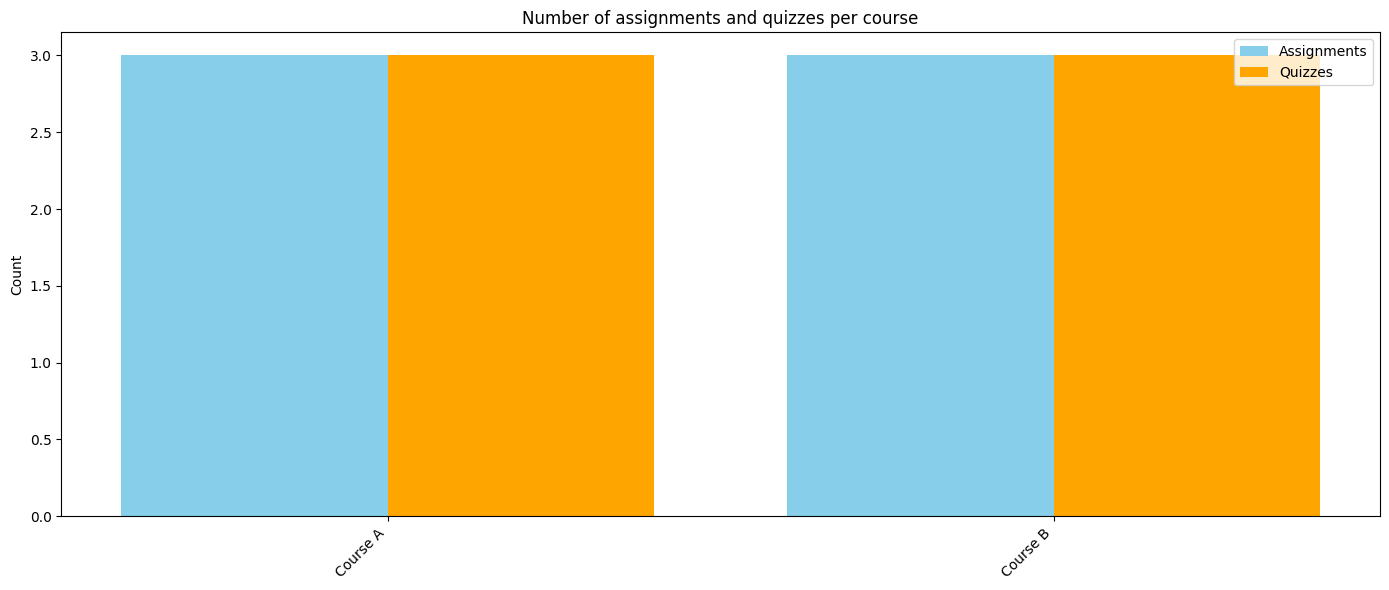

In [371]:
summary = CanvasSummaryVisualizer(data)
summ = CanvasSummaryVisualizer(data2)
summary.plot_overall_scores()
summary.plot_grade_distribution(-1)
summary.plot_grade_distribution(14)
summ.plot_grade_distribution()
summary.plot_num_assessments_per_course()

In [372]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

class CanvasTimeVisualization:
    def __init__(self, data):
        self.data = data

    def plot_item_scores(self, course_index: int = 0):
        """
        Plot scores for assignments and quizzes in separate subplots for one course.
        """
        if not self.data:
            print("No course data available.")
            return
        
        # Try-except statement added
        try:
            if course_index < 0 or course_index >= len(self.data):
                raise IndexError("Invalid Index")
        except IndexError as e:
            print("IndexError:", e)
            return

        # Expected course structure:
        # [course_id, course_name, grade_meta_list, grade_items_list]
        course_id, course_name, _, grade_items = self.data[course_index]

        assignments = []      # list of (date, pct)
        quiz_scores = []      # list of pct values (index-based on x-axis)

        for item in grade_items:
            score = getattr(item, "score", None)
            total = getattr(item, "total", None)
            date = getattr(item, "date", None)

            # Need a valid score and total
            if score is None or total in (None, 0) or score < 0 or total < 0:
                continue

            pct = 100.0 * float(score) / float(total)

            # Assignments: require a valid date so we can plot over time
            if hasattr(item, "isAssignment") and item.isAssignment():
                if date is None:
                    # skip undated assignments for the time plot
                    continue
                assignments.append((date, pct))

            # Quizzes: allow missing dates; we'll plot them by index
            elif hasattr(item, "isQuiz") and item.isQuiz():
                quiz_scores.append(pct)

        # Sort assignments by date
        assignments.sort(key=lambda t: t[0])

        if not assignments and not quiz_scores:
            print("No graded assignments or quizzes with valid scores for this course.")
            return

        # Create a single figure with two subplots (no shared x-axis because the bottom
        # axis is quiz index, not date)
        fig, (ax_assign, ax_quiz) = plt.subplots(2, 1, figsize=(10, 8))

        # --- Assignments subplot (by date) ---
        if assignments:
            dates_a, scores_a = zip(*assignments)
            ax_assign.plot(dates_a, scores_a, marker="o")
            ax_assign.set_xticks(dates_a)
            ax_assign.tick_params(axis="x", rotation=45)
        ax_assign.set_ylabel("Score (%)")
        ax_assign.set_ylim(0, 110)
        ax_assign.set_title(f"Assignments over time\n{course_name} ({course_id})")
        if not assignments:
            ax_assign.text(
                0.5, 0.5, "No assignments",
                ha="center", va="center",
                transform=ax_assign.transAxes
            )

        # --- Quizzes subplot (by index) ---
        if quiz_scores:
            quiz_idx = range(1, len(quiz_scores) + 1)
            ax_quiz.plot(quiz_idx, quiz_scores, marker="s")
            ax_quiz.set_xticks(quiz_idx)
        ax_quiz.set_ylabel("Score (%)")
        ax_quiz.set_ylim(0, 110)
        ax_quiz.set_xlabel("Quiz number")
        ax_quiz.set_title("Quizzes")
        if not quiz_scores:
            ax_quiz.text(
                0.5, 0.5, "No quizzes",
                ha="center", va="center",
                transform=ax_quiz.transAxes
            )

        fig.tight_layout()
        plt.show()

    def get_last_graded_items(self, course_index: int = 0):
        """
        Return the last graded assignment and the last graded quiz for a course.
        Assignments require a date. Quizzes may have missing dates.
        """
        if not self.data:
            print("No course data available.")
            return None, None

        if course_index < 0 or course_index >= len(self.data):
            print("Invalid course_index; must be between 0 and", len(self.data) - 1)
            return None, None

        course_id, course_name, _, grade_items = self.data[course_index]

        assignments = []
        quizzes = []

        for item in grade_items:
            score = getattr(item, "score", None)
            total = getattr(item, "total", None)
            date = getattr(item, "date", None)

            # Must have valid score & total
            if score is None or total is None or score < 0 or total < 0:
                continue

            # Assignments must have date
            if hasattr(item, "isAssignment") and item.isAssignment():
                if date is None:
                    continue
                assignments.append(item)

            # Quizzes do not require date
            elif hasattr(item, "isQuiz") and item.isQuiz():
                quizzes.append(item)

        # Determine "last" graded assignment by date
        last_assignment = None
        if assignments:

            # Try-except statement added
            try: 
                assignments.sort(key=lambda x: x.date)
                last_assignment = assignments[-1]
            except TypeError:
                print("TypeError: Cannot sort assigments by day")
                
        # Determine "last" graded quiz
        # If any quiz has a date, use the latest date.
        last_quiz = None
        if quizzes:
            quizzes_with_dates = [q for q in quizzes if getattr(q, "date", None) is not None]
            if quizzes_with_dates:
                quizzes_with_dates.sort(key=lambda x: x.date)
                last_quiz = quizzes_with_dates[-1]
            else:
                # No dated quizzes, fall back to last scored quiz
                last_quiz = quizzes[-1]

        return last_assignment, last_quiz
    
    def plot_all_last_graded_items_bar(self):
        """
        Bar chart of the last graded assignment and last graded quiz
        for every course.
        """
        if not self.data:
            print("No course data available.")
            return

        course_labels = []
        last_assign_scores = []
        last_quiz_scores = []

        def pct(item):
            try:
                if item.total == 0:
                    raise ZeroDivisionError("Total is zero!")
                return 100.0 * float(item.score) / float(item.total)
            except ValueError as e:
                print("Bad item to caculate percentage:", e)
            except ZeroDivisionError as e:
                print("ZeroDivisionError", e)
            except Exception as e:
                print("Bad item to caculate percentage:", e)
                return None

        # Collect last graded assignment/quiz for each course
        for i, course in enumerate(self.data):
            course_id, course_name, _, _ = course
            course_labels.append(course_name)

            last_assignment, last_quiz = self.get_last_graded_items(i)

            last_assign_scores.append(pct(last_assignment) if last_assignment else None)
            last_quiz_scores.append(pct(last_quiz) if last_quiz else None)

        x = np.arange(len(course_labels))
        width = 0.4   # width of each bar (side by side)

        fig, ax = plt.subplots(figsize=(14, 6))

        # Bars for assignments
        ax.bar(
            x - width/2,
            [v if v is not None else 0 for v in last_assign_scores],
            width,
            label="Last Assignment",
            color="skyblue",
        )

        # Bars for quizzes
        ax.bar(
            x + width/2,
            [v if v is not None else 0 for v in last_quiz_scores],
            width,
            label="Last Quiz",
            color="orange",
        )

        # Set zero-height bars to invisible (for missing values)
        for idx, (a, q) in enumerate(zip(last_assign_scores, last_quiz_scores)):
            if a is None:
                ax.patches[idx].set_alpha(0.2)  # fade
            if q is None:
                ax.patches[idx + len(course_labels)].set_alpha(0.2)

        ax.set_xticks(x)
        ax.set_xticklabels(course_labels, rotation=45, ha="right")
        ax.set_ylabel("Score (%)")
        ax.set_ylim(0, 110)
        ax.set_title("Last graded assignment and quiz across all courses")
        ax.legend()

        fig.tight_layout()
        plt.show()

    def plot_weekly_average_score_heatmap(self):
        """
        Heatmap of weekly average percentage scores for each course.
        Does not account for different weights of quizzes and assignments.
        """
        if not self.data:
            print("No course data available.")
            return

        # For each (course, week) accumulate sum of pct and count
        # key: (course_idx, week_key) where week_key = (year, week)
        sum_scores = defaultdict(float)
        count_scores = defaultdict(int)
        week_keys = set()
        course_names = []

        for ci, (course_id, course_name, _, grade_items) in enumerate(self.data):
            course_names.append(course_name)

            for item in grade_items:
                date = getattr(item, "date", None)
                score = getattr(item, "score", None)
                total = getattr(item, "total", None)

                # Need a dated, valid scored item
                if date is None:
                    continue
                if score is None or total in (None, 0) or score < 0 or total < 0:
                    continue

                pct = 100.0 * float(score) / float(total)
                year, week, _ = date.isocalendar()
                week_key = (year, week)
                week_keys.add(week_key)

                sum_scores[(ci, week_key)] += pct
                count_scores[(ci, week_key)] += 1

        if not week_keys:
            print("No dated graded items with valid scores to build heatmap.")
            return

        # Sort weeks and build labels
        week_keys = sorted(week_keys)
        week_labels = [f"{y}-W{w:02d}" for (y, w) in week_keys]

        n_courses = len(course_names)
        n_weeks = len(week_keys)

        # Initialize matrix with NaNs so weeks with no scores show as empty
        mat = np.full((n_courses, n_weeks), np.nan, dtype=float)
        week_index = {k: j for j, k in enumerate(week_keys)}

        for (ci, wk), s in sum_scores.items():
            j = week_index[wk]
            c = count_scores[(ci, wk)]
            mat[ci, j] = s / c

        # Try-except statement added
        try: 
            # Plot heatmap
            plt.figure(figsize=(14, 6))
            im = plt.imshow(mat, aspect="auto", cmap="viridis", vmin=0, vmax=100)
            plt.colorbar(im, label="Average score (%)")

            # Axis labels
            plt.yticks(range(n_courses), course_names)
            plt.xticks(range(n_weeks), week_labels, rotation=45, ha="right")

            plt.xlabel("Week")
            plt.ylabel("Course")
            plt.title("Weekly average percentage score by course")
            plt.tight_layout()
            plt.show()
        except RecursionError as e:
            print(f"Plotting error {e}")
        

In [373]:
from datetime import date

course_name = ["Course A", "Course B", "Course C"]
courseid = [i+1 for i in range(course_name.__len__())]
final_score = (70, 85, 100)
grade_meta_data =[[{
                'html_url': 'https://canvas.ubc.ca/courses/174247/grades/2650436',
                'current_grade': None,
                'current_score': None,
                'final_grade': None,
                'final_score': -i, # testing with the -
            }] for i in final_score]

class FakeQuizItem:
    def __init__(self, score, total, date):
        self.score = score
        self.total = total
        self.date = date

    def isAssignment(self): return False
    def isQuiz(self): return True


class FakeAssignItem:
    def __init__(self, score, total, date):
        self.score = score
        self.total = total
        self.date = date

    def isAssignment(self): return True
    def isQuiz(self): return False

fake_grades = [FakeAssignItem(8, 10, date(2025, 1,1) ),FakeAssignItem(15, 20, date(2025, 1,2)), FakeAssignItem(5, 5, date(2025, 1,3)),
                FakeQuizItem(8,10, date(2025, 1, 12)), FakeQuizItem(17, 20, date(2025, 1, 13)), FakeQuizItem(4.5, 0, date(2025, 1, 14))]

data = [[courseid[i], course_name[i], grade_meta_data[i], fake_grades] 
        for i in range(3)]



ZeroDivisionError Total is zero!
ZeroDivisionError Total is zero!
ZeroDivisionError Total is zero!


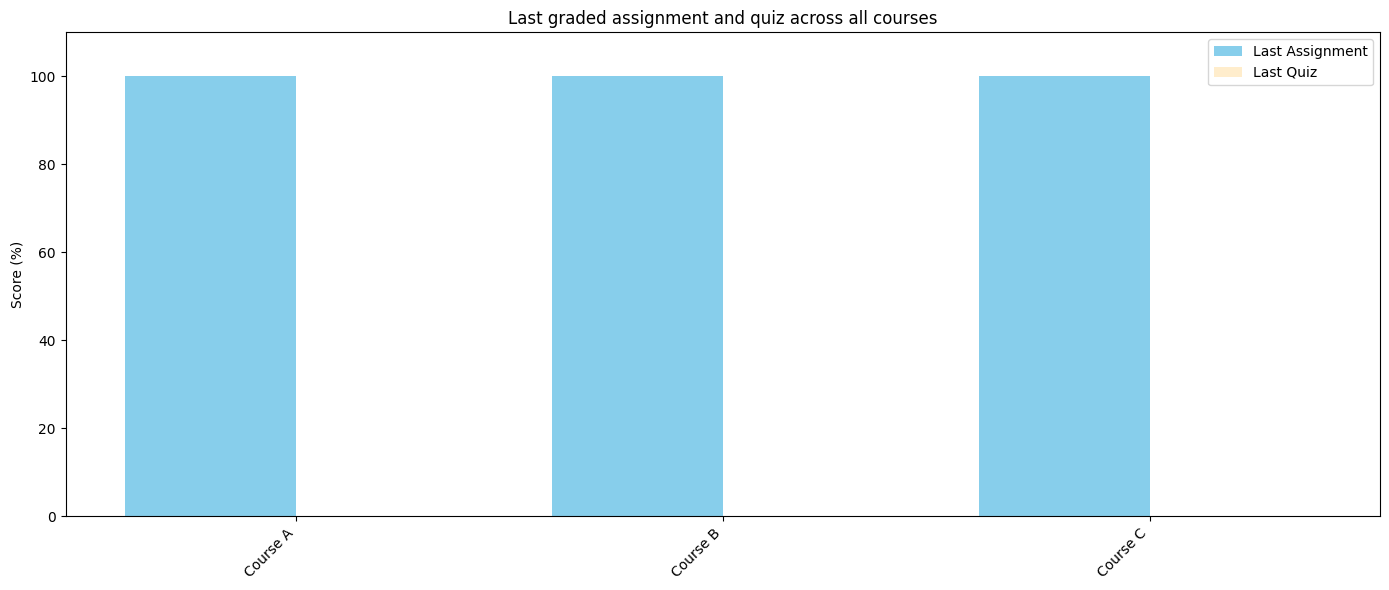

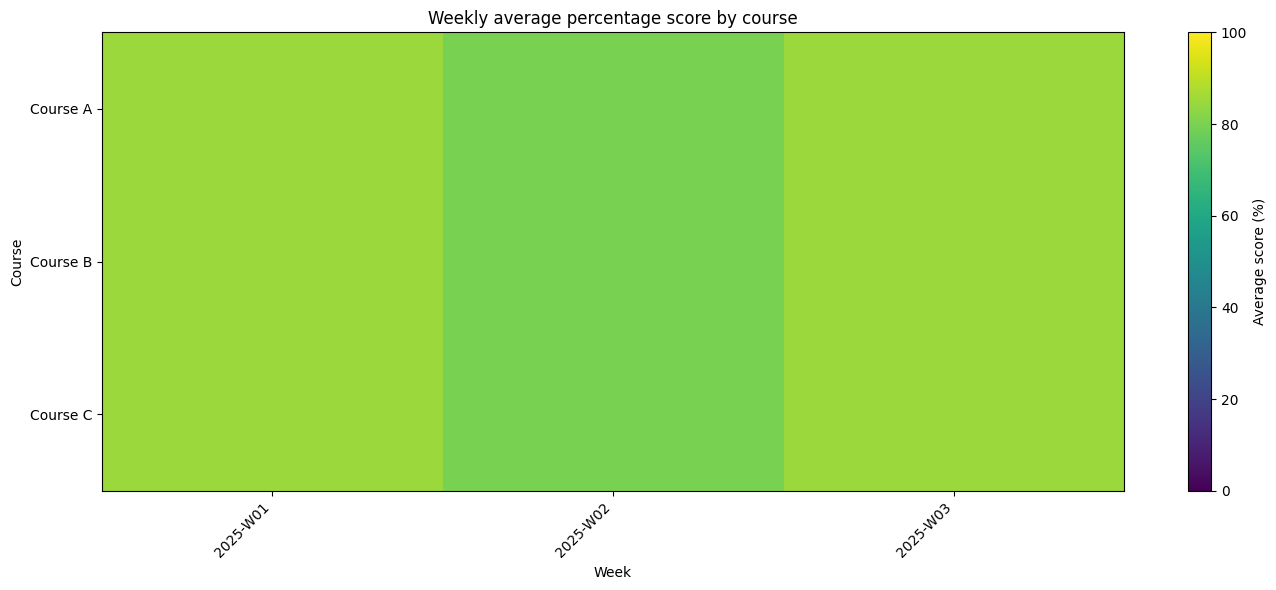

In [374]:
tm = CanvasTimeVisualization(data)
tm.plot_all_last_graded_items_bar()
tm.plot_weekly_average_score_heatmap()